# Week2_1 Assignment

# [BASIC](#Basic)
- BERT 모델의 hidden state에서 **특정 단어의 embedding을 여러 방식으로 추출 및 생성**할 수 있다.

# [CHALLENGE](#Challenge)
- **cosine similarity 함수를 구현**할 수 있다. 
- **단어들의 유사도**를 cosine similarity로 비교할 수 있다. 

# [ADVANCED](#Advanced)
- 문장 embedding을 구해 **문장 간 유사도**를 구할 수 있다.

### Reference
- [BERT word embedding & sentence embedding tutorial 영문 블로그](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#33-creating-word-and-sentence-vectors-from-hidden-states)

In [ ]:
import os
import sys
import pandas as pd
import numpy as np 
import torch
import random

## Basic

### BERT 모델과 토크나이저 로드   
- 두 사람의 대화에서 (단어 및 문장의) embedding을 생성하고자 한다. 아래 대화를 BERT 모델에 입력해 출력값 중 "hidden states"값을 가져오자.
- `Hidden States`는 3차원 텐서를 가지고 있는 list 타입이다. List에는 BERT 모델의 각 layer마다의 hidden state 3차원 텐서를 갖고 있으며 각 텐서는 (batch_size, sequence_length, hidden_size) shape을 가진다. BERT-base 모델은 12 layer를 갖고 있고 이와 별도로 Embedding Layer 1개를 더 갖고 있기 때문에 `len(hidden states)`는 13개가 된다. 
    - batch_size: 학습 시 설정한 배치 사이즈. 또는 BERT 모델에 입력된 문장의 개수
    - sequence_length: 문장의 token의 개수. 
    - hidden size: token의 embedding size 
- Reference
    - [BertTokenizer.tokenize() 함수의 매개변수 설명](https://huggingface.co/transformers/v3.0.2/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.__call__)
    - [BERTModel.forward() 함수의 매개변수 및 리턴 값 설명](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel.forward)

In [ ]:
# !pip install transformers

     |████████████████████████████████| 3.5 MB 8.2 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 39.5 MB/s 
     |████████████████████████████████| 6.8 MB 36.9 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-cased")
model_bert = BertModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
normal_person = ["what do you do when you have free time?"]
nerd = ["I code. code frees my minds, body and soul."]
normal_person.append("(what a nerd...) coding?")
nerd.append("Yes. coding is the best thing to do in the free time.")

for i in range(len(normal_person)):
    print(f"Normal Person asked: {normal_person[i]}")
    print(f"Nerd answers: {nerd[i]}")

Normal Person asked: what do you do when you have free time?
Nerd answers: I code. code frees my minds, body and soul.
Normal Person asked: (what a nerd...) coding?
Nerd answers: Yes. coding is the best thing to do in the free time.


In [ ]:
# 매개변수 설명
# truncation <- max_len 넘어가지 않도록 자르기
# padding <- max(seq_len, max_len) zero padding
# return_tensors <- return 2d tensor 

inputs = tokenizer_bert(
    text = normal_person,
    text_pair = nerd,
    truncation = True,
    padding = "longest", 
    return_tensors='pt'
    )

print(inputs['input_ids'].shape)

torch.Size([2, 28])


###output 설명 
![](https://images.velog.io/images/crosstar1228/post/2ca6533e-d343-4bbd-9ef0-d87e50ee29af/image.png)
- `input_ids` : 
  - input의 token에 대응되는 id. model로 들어감. 
  - token embedding에 해당
- `token_type_ids`: 
  - input의 token type. model로 들어감. 
  - segment embedding에 해당
- `attention_mask`: 
  - 각 token 별 attention에 해당하는 값
  - positional embedding에 해당 (확실치 않음)

In [ ]:
inputs['input_ids'][0]

tensor([  101,  1184,  1202,  1128,  1202,  1165,  1128,  1138,  1714,  1159,
          136,   102,   146,  3463,   119,  3463,  1714,  1116,  1139, 10089,
          117,  1404,  1105,  3960,   119,   102,     0,     0])

In [ ]:
inputs['token_type_ids']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])

In [ ]:
# decoding : 어떻게 decoding 되는지 확인
for i in range(len(inputs['input_ids'])):
    print(f"Coversation {i} -> '{tokenizer_bert.decode(inputs['input_ids'][i])}'")

Coversation 0 -> '[CLS] what do you do when you have free time? [SEP] I code. code frees my minds, body and soul. [SEP] [PAD] [PAD]'
Coversation 1 -> '[CLS] ( what a nerd... ) coding? [SEP] Yes. coding is the best thing to do in the free time. [SEP]'


In [ ]:
# "code" 단어의 token id(각 단어에게 고유하게 주어진 id)를 출력
tokenizer_bert.encode('code', add_special_tokens=False)

[3463]

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
# 입력 데이터와 BERT 모델을 "GPU" 장치로 로드함
inputs = inputs.to(device)
model_bert.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

###📌 유의할 점 : hidden state가 왜 12개가 아니고 13개일까?
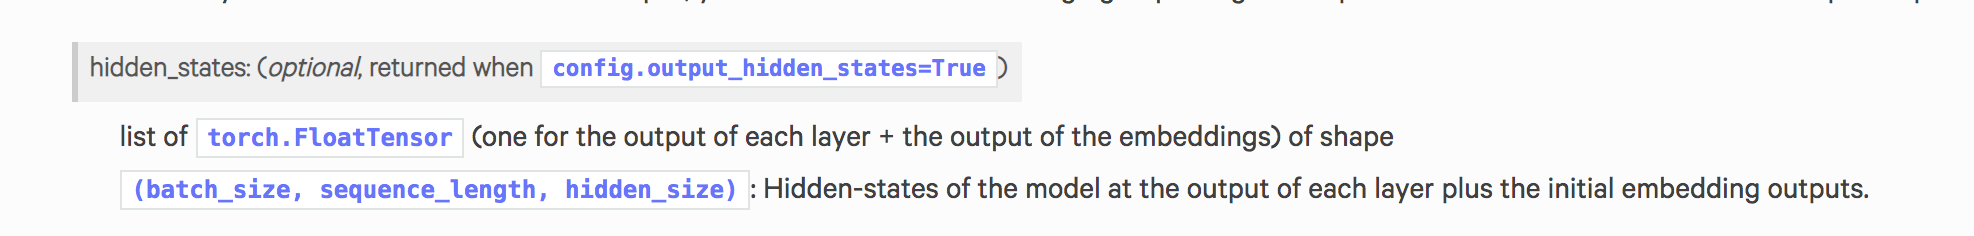
- https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutput
- 첫layer는 feed-forward layer의 embedding output으로서 BERT 모델의 attention이 가지고 있는 hidden layer가 아님. 따라서 제외.

In [ ]:
# 입력 데이터를 BERT 모델에 넣어 출력값을 가져옴
outputs = model_bert(
    **inputs, 
    output_hidden_states=True
    )

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [ ]:
hidden_states = outputs['hidden_states']
print(f"# layers : {len(hidden_states)}")
print(f"tensor shape in each layer : {hidden_states[-1].shape}")

# layers : 13
tensor shape in each layer : torch.Size([2, 28, 768])


###  Q1. 1번째 sequence (문장)에서 "code"라는 단어의 인덱스를 모두 반환하라.
- "code" 단어는 총 2개 존재 

In [ ]:
def get_index(seq, word):
  token_num=tokenizer_bert.encode(token, add_special_tokens=False)[0] # 해당 token number encoding
  # print(token_num)
  # print(seq)
  return (seq==token_num).nonzero(as_tuple=True)[0] # 부합하는 token indexing

# input
# seq1: 1번째 sequence
# token: 단어
seq1 = inputs['input_ids'][0]
token = "code"

# output
token_index = get_index(seq1, token)
print(token_index)

tensor([13, 15], device='cuda:0')


### Q2. 1번째 sequence의 1번째 "code" 토큰의 embedding을 여러가지 방식으로 구하고자 한다. BERT hidden state를 다음의 방식으로 인덱싱해 embedding을 구하라
- 1 layer
- last layer
- sum all 12 layers
- sum last 4 layers
- concat last 4 layers
- average last 4 layers

In [ ]:
# hidden layer에 대한 indexing은 1부터 시작
# 1 layer
first_layer_emb = hidden_states[1][0,token_index[0]] # [첫 layer][첫 문장, 첫번째 code의 index]
print(first_layer_emb.shape) 

# last layer
last_layer_emb = hidden_states[-1][0,token_index[0]] # [마지막 hidden layer][첫 문장, 첫번째 code의 index] 
print(last_layer_emb.shape)

# sum all 12 layers
sum_all_layer_emb = sum(hidden_states[1:])[0,token_index[0]]
print(sum_all_layer_emb.shape)

# sum last 4 layers
sum_last4_layer_emb = sum(hidden_states[-4:])[0,token_index[0]]
print(sum_last4_layer_emb.shape)

# concat last 4 layers
concat_last4_layer_emb = torch.cat(hidden_states[-4:], dim=2)[0,token_index[0]] # embedding vector(dim=2)의 차원을 늘여야 원하는 값을 얻을 수 있음
print(concat_last4_layer_emb.shape)

# mean last 4 layers
mean_last4_layer_emb = (sum(hidden_states[-4:])/4)[0,token_index[0]]
print(mean_last4_layer_emb.shape)

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072])
torch.Size([768])


## Challenge

### Q3. `sum_last_four_layer` 방식으로 1번째 sequence의 2개의 "code" 토큰 사이의 코사인 유사도를 계산하라

In [ ]:
def cosine_similarity_manual(x, y, small_number=1e-8):
    x_norm=torch.linalg.norm(x)
    y_norm=torch.linalg.norm(y)
    return torch.dot(x,y)/max(x_norm*y_norm,small_number)

# input
# x: 1번째 sequence의 1번째 "code"의 sum_last_four_layer 방식 embedding
# y: 1번째 sequence의 2번째 "code"의 sum_last_four_layer 방식 embedding
x = sum(hidden_states[-4:])[0,token_index[0]]
y = sum(hidden_states[-4:])[0,token_index[1]]

# output
score = cosine_similarity_manual(x, y)
print(score)

tensor(0.8427, device='cuda:0', grad_fn=<DivBackward0>)


### Q4. 2번째 sequence에서 "coding"이라는 토큰의 위치를 반환하라

In [ ]:
# Q1과 동일한 문제 

# input
# seq2: 2번째 sequence
# token: 단어
seq2 = inputs['input_ids'][1]
token = "coding"

# output
# Q1에서 구현한 함수 사용
token_index = get_index(seq2, token)
print(token_index)

tensor([10, 15], device='cuda:0')


### Q5. `concat_last4_layer_emb` 방식으로 2번째 sequence의 2개의 "coding" 토큰 사이의 코사인 유사도를 계산하라

In [ ]:
# Q3과 동일한 문제

# input
# x: 2번째 sequence의 1번째 "coding"의 concat_last4_layer_emb
# y: 2번째 sequence의 2번째 "coding"의 concat_last4_layer_emb

x = torch.cat(hidden_states[-4:], dim=2)[1,token_index[0]]
y = torch.cat(hidden_states[-4:], dim=2)[1,token_index[1]]

# output
# Q3에서 구현한 함수 사용
score = cosine_similarity_manual(x, y)
print(score)

tensor(0.8682, device='cuda:0', grad_fn=<DivBackward0>)


### Q6. 2번째 sequence에서 랜덤하게 토큰 하나를 뽑아보자. 그 랜덤 토큰과 2번째 sequence의 2번째 "coding" 토큰의 코사인 유사도를 계산해보자

In [ ]:
# input
# random_idx: random 모듈 사용하여 뽑은 랜덤 토큰의 인덱스
# random_word: random_idx에 해당하는 단어
# x: 2번째 sequence의 2번째 "coding" 토큰의 concat_last4_layer_emb
# y: 랜덤 토큰의 concat_last4_layer_emb

random_idx = random.randint(0,len(inputs['input_ids'][1]))
# print(len(inputs['input_ids'][1]),random_idx)
random_word = tokenizer_bert.decode(inputs['input_ids'][1][random_idx], add_special_tokens=False)
print(random_word)
x = torch.cat(hidden_states[-4:], dim=2)[1,token_index[1]] # 2번째 coding token
y = torch.cat(hidden_states[-4:], dim=2)[1,random_idx] # random index의 token

# output
# Q3에서 구현한 함수 사용
score = cosine_similarity_manual(x, y)
print(f'similarity score between \'coding\' and {random_word}:')
print(score)

f r e e
similarity score between 'coding' and f r e e:
tensor(0.5569, device='cuda:0', grad_fn=<DivBackward0>)


## Advanced

### Q7. 1번째 sequence와 2번째 sequence의 문장 유사도를 구해보자. 문장의 엠베딩은 마지막 레이어의 첫번째 토큰 ('[CLS]')으로 생성한다.


In [ ]:
# input
# x: 1번째 sequence의 embedding
# y: 2번째 sequence의 embedding
x =  hidden_states[-1][0,0] # [마지막 output layer][첫 문장, 첫 토큰]
y =  hidden_states[-1][1,0] # [마지막 output layer][두 번째 문장, 첫 토큰]

# x =  outputs['last_hidden_state'][0,0] # 위와 같이 bertmodel의 output중 'last_hidden_state'를 indexing해서 해도 결과는 같음
# y =  outputs['last_hidden_state'][1,0]

# output
# Q3에서 구현한 함수 사용
score =  cosine_similarity_manual(x, y)
print(score)

tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>)
